In [1]:
import os
import datetime as dt  # Python standard library datetime  module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from eofs.xarray import Eof

from utils import data_path

In [2]:
#**parameters & hyperparameters

RSCV = True
path_output='output_path/output.nc'

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5,55, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 25]
# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 8, 12]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [3]:
# # Download data into Google drive. Downloading the 914MB can take ~25min.
# import os
# data_path = '../data'
# if not os.path.exists(data_path):
#     os.makedirs(data_path)
# if not os.path.exists(data_path + '/train_val.tar.gz'):
#     # todo: double-check that version matches https://doi.org/10.5281/zenodo.7064302
#     ! wget https://zenodo.org/record/7064308/files/train_val.tar.gz -P $data_path
#     ! tar -xvf "$data_path/train_val.tar.gz" -C $data_path
# if not os.path.exists(data_path + '/test.tar.gz'):
#     ! wget https://zenodo.org/record/7064308/files/test.tar.gz -P $data_path
#     ! tar -xvf "$data_path/test.tar.gz" -C $data_path
# ## Check all files in your local environment
# #print("============== Files =============")
# #! ls

In [4]:
# Utilities for normalizing the emissions data
min_co2 = 0.
max_co2 = 2400
def normalize_co2(data):
    return data / max_co2

def un_normalize_co2(data):
    return data * max_co2

min_ch4 = 0.
max_ch4 = 0.6
def normalize_ch4(data):
    return data / max_ch4

def un_normalize_ch4(data):
    return data * max_ch4

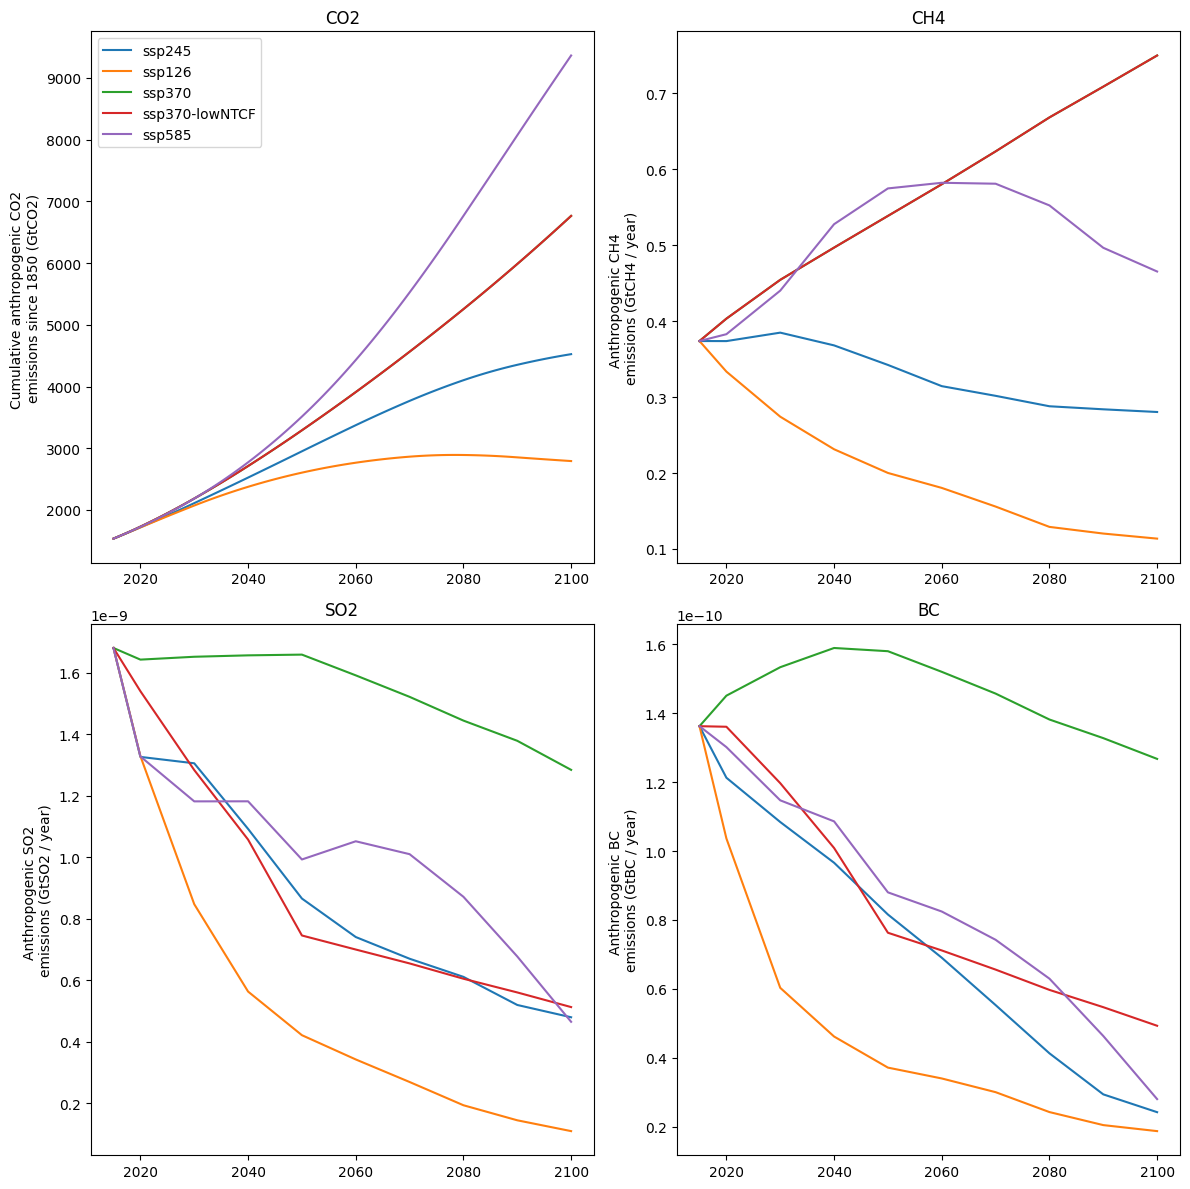

In [5]:
from glob import glob

inputs = glob(data_path + "inputs_s*.nc")
SECONDS_IN_YEAR = 60*60*24*365 #s

fig, axes = plt.subplots(2, 2, figsize=(12,12))

for input in inputs:
    label=input.split('_')[1][:-3]
    X = xr.open_dataset(input)
    x = range(2015, 2101)

    weights = np.cos(np.deg2rad(X.latitude))
    
    axes[0, 0].plot(x, X['CO2'].data, label=label)
    axes[0, 0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
    axes[0, 1].plot(x, X['CH4'].data, label=label)
    axes[0, 1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")
    # FIXME: Not sure where this factor of 1000 comes from...! Maybe the CEDS data is really g/m-2/s?
    axes[1, 0].plot(x, X['SO2'].weighted(weights).sum(['latitude', 'longitude']).data*SECONDS_IN_YEAR*1e-9, label=label)
    axes[1, 0].set_ylabel("Anthropogenic SO2 \nemissions (GtSO2 / year)")
    axes[1, 1].plot(x, X['BC'].weighted(weights).sum(['latitude', 'longitude']).data*SECONDS_IN_YEAR*1e-9, label=label)
    axes[1, 1].set_ylabel("Anthropogenic BC \nemissions (GtBC / year)")

axes[0, 0].set_title('CO2')
axes[0, 1].set_title('CH4')
axes[1, 0].set_title('SO2')
axes[1, 1].set_title('BC')
axes[0, 0].legend()
plt.tight_layout()

test_data_path=data_path+'inputs_ssp245.nc'

In [6]:
# Get one combined historical + ssp585 + ssp126 + ssp370 timeseries for now
X = xr.concat([xr.open_dataset(data_path + 'inputs_historical.nc'), xr.open_dataset(data_path + 'inputs_ssp585.nc'),xr.open_dataset(data_path+ 'inputs_ssp126.nc'),xr.open_dataset(data_path+ 'inputs_ssp370.nc'),xr.open_dataset(data_path+ 'inputs_hist-aer.nc'),xr.open_dataset(data_path+ 'inputs_hist-GHG.nc')], dim='time').compute()

# Take the average member for the historical, ssp585, ssp126, ssp370, hist-aer, hist-ghg
Y = xr.concat([xr.open_dataset(data_path + 'outputs_historical.nc').mean(dim="member"), xr.open_dataset(data_path + 'outputs_ssp585.nc').mean(dim="member"),xr.open_dataset(data_path+ 'outputs_ssp126.nc').mean(dim="member"),xr.open_dataset(data_path+ 'outputs_ssp370.nc').mean(dim="member"),xr.open_dataset(data_path+ 'outputs_hist-aer.nc').mean(dim="member"),xr.open_dataset(data_path+ 'outputs_hist-GHG.nc').mean(dim="member")], dim='time').compute()


# Convert the precip values to mm/day
Y["pr"] *= 86400
Y["pr90"] *= 86400

X["time"]=np.arange(1, 424 + 165 + 165) ## 165+86+86+86+65+165+1
Y["time"]=np.arange(1, 424 + 165 + 165)
        

In [7]:
## proj = ccrs.PlateCarree()
#fig = plt.figure(figsize=(18, 8))
#plt.subplot(221)
#np.log(X["SO2"].sel(time=1850)).plot(vmin=-27, vmax=-20)
## plt.gca().coastlines()
#plt.gca().set_title('1850')
#
#plt.subplot(222)
#np.log(X["SO2"].sel(time=1970)).plot(vmin=-27, vmax=-20)
## plt.gca().coastlines()
#plt.gca().set_title('1970')
#
#plt.subplot(223)
#np.log(X["SO2"].sel(time=2020)).plot(vmin=-27, vmax=-20)
## plt.gca().coastlines()
#plt.gca().set_title('2020')
#
#plt.subplot(224)
#m=np.log(X["SO2"].sel(time=2100)).plot(vmin=-27, vmax=-20)
## plt.gca().coastlines()
#plt.gca().set_title('2100')
#
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
#cbar = fig.colorbar(m, cax=cbar_ax)
#cbar.set_label('Log anthropogenic SO2 emissions (log kg / m2 / s)')

In [8]:
#fig = plt.figure(figsize=(12, 8))
#plt.subplot(221)
#Y["tas"].sel(time=2100).plot(vmin=0, cmap='Reds')
#plt.gca().set_title('Annual Mean')
#
#plt.subplot(222)
#Y["diurnal_temperature_range"].sel(time=2100).plot(vmin=-4, vmax=4, cmap='RdBu_r' )
#plt.gca().set_title('Mean diurnal range')
#
#plt.subplot(223)
##  Convert precip to mm/day
#Y["pr"].sel(time=2100).plot(vmin=-5, vmax=5, cmap='RdBu_r')
#plt.gca().set_title('Annual Mean')
#
#plt.subplot(224)
#Y["pr90"].sel(time=2100).plot(vmin=-5, vmax=5, cmap='RdBu_r')
#plt.gca().set_title('Annual 90th percentile')

In [9]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
bc_solver = Eof(X['BC'])

# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
bc_eofs = bc_solver.eofsAsCorrelation(neofs=5)
bc_pcs = bc_solver.pcs(npcs=5, pcscaling=1)

In [10]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
so2_solver = Eof(X['SO2'])

# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
so2_eofs = so2_solver.eofsAsCorrelation(neofs=5)
so2_pcs = so2_solver.pcs(npcs=5, pcscaling=1)


In [11]:
# Convert the Principle Components of the aerosol emissions (calculated above) in to Pandas DataFrames
bc_df = bc_pcs.to_dataframe().unstack('mode')
bc_df.columns = [f"BC_{i}" for i in range(5)]

so2_df = so2_pcs.to_dataframe().unstack('mode')
so2_df.columns = [f"SO2_{i}" for i in range(5)]

In [12]:
# Bring the emissions data back together again and normalise
leading_historical_inputs = pd.DataFrame({
    "CO2": normalize_co2(X["CO2"].data),
    "CH4": normalize_ch4(X["CH4"].data)
}, index=X["CO2"].coords['time'].data)

# Combine with aerosol EOFs
leading_historical_inputs=pd.concat([leading_historical_inputs, bc_df, so2_df], axis=1)

In [13]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data.mean()

In [14]:
y_inp_tas=Y["tas"].stack(dim=["lat", "lon"])
y_inp_pr=Y["pr"].stack(dim=["lat", "lon"])
y_inp_pr90=Y["pr90"].stack(dim=["lat", "lon"])
y_inp_dtr=Y["diurnal_temperature_range"].stack(dim=["lat", "lon"])

In [15]:
df_y_input_tas = pd.DataFrame(y_inp_tas.to_pandas())
df_y_input_pr = pd.DataFrame(y_inp_pr.to_pandas())
df_y_input_pr90 = pd.DataFrame(y_inp_pr90.to_pandas())
df_y_input_dtr = pd.DataFrame(y_inp_dtr.to_pandas())

Xy_train_tas_ = pd.concat([leading_historical_inputs, df_y_input_tas], axis=1)
Xy_train_pr_ = pd.concat([leading_historical_inputs, df_y_input_pr], axis=1)
Xy_train_pr90_ = pd.concat([leading_historical_inputs, df_y_input_pr90], axis=1)
Xy_train_dtr_ = pd.concat([leading_historical_inputs, df_y_input_dtr], axis=1)

In [16]:
Xy_train_tas = Xy_train_tas_.to_numpy()
Xy_train_pr = Xy_train_pr_.to_numpy()
Xy_train_pr90 = Xy_train_pr90_.to_numpy()
Xy_train_dtr = Xy_train_dtr_.to_numpy()

In [17]:
n_inp=leading_historical_inputs.shape[1]
n_iout=Xy_train_tas_.shape[1]

X_train_tas=Xy_train_tas[:,0:n_inp]
y_train_tas=Xy_train_tas[:,n_inp:n_iout]

X_train_pr=Xy_train_pr[:,0:n_inp]
y_train_pr=Xy_train_pr[:,n_inp:n_iout]

X_train_pr90=Xy_train_pr90[:,0:n_inp]
y_train_pr90=Xy_train_pr90[:,n_inp:n_iout]

X_train_dtr=Xy_train_dtr[:,0:n_inp]
y_train_dtr=Xy_train_dtr[:,n_inp:n_iout]


In [18]:
reg0 = RandomForestRegressor(random_state=0)
reg1 = RandomForestRegressor(random_state=0)
reg2 = RandomForestRegressor(random_state=0)
reg3 = RandomForestRegressor(random_state=0)

if(RSCV==False):
    rf_tas = reg0.fit(X_train_tas,y_train_tas)
    rf_pr = reg1.fit(X_train_pr,y_train_pr)
    rf_pr90 = reg2.fit(X_train_pr90,y_train_pr90)
    rf_dtr = reg3.fit(X_train_dtr,y_train_dtr)
else:
    rf_random0 = RandomizedSearchCV(estimator = reg0, param_distributions = random_grid, n_iter = 29, cv = 3, verbose=2, n_jobs = -1)
    rf_random1 = RandomizedSearchCV(estimator = reg1, param_distributions = random_grid, n_iter = 29, cv = 3, verbose=2, n_jobs = -1)
    rf_random2 = RandomizedSearchCV(estimator = reg2, param_distributions = random_grid, n_iter = 29, cv = 3, verbose=2, n_jobs = -1)
    rf_random3 = RandomizedSearchCV(estimator = reg3, param_distributions = random_grid, n_iter = 29, cv = 3, verbose=2, n_jobs = -1)

    #n_iter = 29
    
    rf_tas = rf_random0.fit(X_train_tas,y_train_tas)
    rf_pr = rf_random1.fit(X_train_pr,y_train_pr)
    rf_pr90 = rf_random2.fit(X_train_pr90,y_train_pr90)
    rf_dtr = rf_random3.fit(X_train_dtr,y_train_dtr)

Fitting 3 folds for each of 29 candidates, totalling 87 fits
[CV] END bootstrap=False, max_depth=45, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=12, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=55, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=150; total time= 2.0min


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, max_depth=55, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=150; total time= 2.0min
[CV] END bootstrap=False, max_depth=25, max_features=auto, min_samples_leaf=8, min_samples_split=25, n_estimators=150; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=12, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=12, min_samples_split=15, n_estimators=300; total time= 3.1min
[CV] END bootstrap=False, max_depth=55, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=100; total time= 1.2min
[CV] END bootstrap=False, max_dept

/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
57 fits failed out of a total of 87.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py", line 638,

Fitting 3 folds for each of 29 candidates, totalling 87 fits
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=12, min_samples_split=15, n_estimators=300; total time= 3.7min
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=12, min_samples_split=5, n_estimators=100; total time=  50.9s


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=55, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=100; total time= 1.1min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time= 1.1min
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=12, min_samples_split=10, n_estimators=200; total time= 2.6min
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=12, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=35, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 1.7min
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=150; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=15, n_estimators=100; total time=  42.5s
[CV] END bootstrap=False, max_dep

/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
42 fits failed out of a total of 87.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
17 fits failed with the following error:
Traceback (most recent call last):
  File "/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py", line 638,

Fitting 3 folds for each of 29 candidates, totalling 87 fits
[CV] END bootstrap=True, max_depth=35, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time= 1.6min
[CV] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=12, min_samples_split=15, n_estimators=300; total time= 2.2min
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=300; total time= 1.6min
[CV] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=8, min_samples_split=25, n_estimators=300; total time=   0.4s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=   0.4s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time= 1.2min


/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=45, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=12, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=15, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=12, min_samples_split=15, n_estimators=300; total time=   0.2s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=12, min_samples_split=15, n_estimators=300; total time=   0.2s
[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=25, n_estimators=250; total time=   0.2s
[CV] END bootstrap=False, max_d

/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
54 fits failed out of a total of 87.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py", line 638,

[CV] END bootstrap=False, max_depth=35, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 4.7min
[CV] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  48.9s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=250; total time=   0.2s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=250; total time=   0.3s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=250; total time=   0.3s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=12, min_samples_split=5, n_estimators=300; total time= 3.0min
[CV] END bootstrap=False, max_depth=35, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, max_dept

/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=55, max_features=auto, min_samples_leaf=12, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=150; total time=   0.3s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=12, min_samples_split=15, n_estimators=150; total time= 1.8min
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=300; total time= 4.4min
[CV] END bootstrap=True, max_depth=55, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=250; total time=   0.3s
[CV] END bootstrap=False, max_depth=45, max_features=sqrt, min_samples_leaf=8, min_samples_split=25, n_estimators=200; total time= 1.9min
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=300; total time= 1.4min
[CV] END bootstrap=True, max_depth=

/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
51 fits failed out of a total of 87.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py", line 638,

In [19]:
if(RSCV==True):
    print(rf_tas.best_params_)
    print(rf_pr.best_params_)
    print(rf_pr90.best_params_)
    print(rf_dtr.best_params_)

{'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}
{'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}
{'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': False}
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 25, 'bootstrap': True}


In [21]:
## Test on SSP245

# test_Y = xr.open_dataset(data_path + 'test-data/outputs_ssp245_solution.nc').compute()
# test_X = xr.open_dataset(data_path + 'test-data/inputs_ssp245-2.nc').compute()
test_Y = xr.open_dataset(data_path + '/outputs_ssp245.nc').compute()
test_X = xr.open_dataset(data_path + '/inputs_ssp245.nc').compute()

tas_truth = test_Y["tas"].mean('member')
pr_truth = test_Y["pr"].mean('member') * 86400
pr90_truth = test_Y["pr90"].mean('member') * 86400
dtr_truth = test_Y["diurnal_temperature_range"].mean('member')

test_inputs = pd.DataFrame({
    "CO2": normalize_co2(test_X["CO2"].data),
    "CH4": normalize_ch4(test_X["CH4"].data)
}, index=test_X["CO2"].coords['time'].data)

### Combine with aerosol EOFs
test_inputs=pd.concat([test_inputs, 
                       bc_solver.projectField(test_X["BC"], neofs=5, eofscaling=1).to_dataframe().unstack('mode').rename(columns={i:f"BC_{i}" for i in range(5)}),
                       so2_solver.projectField(test_X["SO2"], neofs=5, eofscaling=1).to_dataframe().unstack('mode').rename(columns={i:f"_{i}" for i in range(5)}),
                       ], axis=1)


In [22]:
#newly added block by pthak006

# Convert tuple column names to strings
test_inputs.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in test_inputs.columns]

# Now the columns should all be strings. Let's print them to confirm.
print(test_inputs.columns)


Index(['CO2', 'CH4', 'pseudo_pcs_BC_0', 'pseudo_pcs_BC_1', 'pseudo_pcs_BC_2',
       'pseudo_pcs_BC_3', 'pseudo_pcs_BC_4', 'pseudo_pcs__0', 'pseudo_pcs__1',
       'pseudo_pcs__2', 'pseudo_pcs__3', 'pseudo_pcs__4'],
      dtype='object')


In [23]:
m_out_t = rf_tas.predict(test_inputs)
m_out_p = rf_pr.predict(test_inputs)
m_out_p90 = rf_pr90.predict(test_inputs)
m_out_d = rf_dtr.predict(test_inputs)

m_out_tas = m_out_t.reshape(86, 96, 144)
m_out_pr = m_out_p.reshape(86, 96, 144)
m_out_pr90 = m_out_p90.reshape(86, 96, 144)
m_out_dtr = m_out_d.reshape(86, 96, 144)

/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/cauliflower/miniconda3/envs/newenv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [24]:
#xr_output['pr'].sel(time=2015).plot()

In [25]:
#m_tas.sel(sample=35).plot(cmap="coolwarm", norm=divnorm,
#                          cbar_kwargs={"label":"Temperature change / K"})
#plt.gca().set_title("Emulated 2050")

In [26]:
#in the next block to resolve the error output_path folder added to the baseline_model directory

In [27]:
xr_output=xr.Dataset(coords={'time': test_X.time.values, 'lat': test_X.latitude.values, 'lon': test_X.longitude.values})
xr_output["tas"]=(['time', 'lat', 'lon'],  m_out_tas)
xr_output["diurnal_temperature_range"]=(['time', 'lat', 'lon'],  m_out_dtr)
xr_output["pr"]=(['time', 'lat', 'lon'],  m_out_pr)
xr_output["pr90"]=(['time', 'lat', 'lon'],  m_out_pr90)
    
#save output to netcdf 
xr_output.to_netcdf(path_output,'w')

In [28]:
#coords={'lon': (['x', 'y'], lon),
#                    'lat': (['x', 'y'], lat),
#                    'time': pd.date_range('2014-09-06', periods=3)})
#temp=np.array([[25, 24, 20, -12],[23, 21, 22, -11]])
#xr_output["Temperature"]=(['x', 'y', 'time'],  temp)

In [29]:
print(f"RMSE: {get_rmse(tas_truth[35], m_out_tas[35])}")
print(f"RMSE: {get_rmse(tas_truth[85], m_out_tas[85])}")
print(f"RMSE: {get_rmse(tas_truth[30:40], m_out_tas[30:40])}")
print(f"RMSE: {get_rmse(tas_truth[75:], m_out_tas[75:])}")
print(f"RMSE: {get_rmse(tas_truth[35:], m_out_tas[35:])}")
print("\n")

print(f"RMSE: {get_rmse(dtr_truth[35], m_out_dtr[35])}")
print(f"RMSE: {get_rmse(dtr_truth[85], m_out_dtr[85])}")
print(f"RMSE: {get_rmse(dtr_truth[30:40], m_out_dtr[30:40])}")
print(f"RMSE: {get_rmse(dtr_truth[75:], m_out_dtr[75:])}")
print(f"RMSE: {get_rmse(dtr_truth[35:], m_out_dtr[35:])}")
print("\n")

print(f"RMSE: {get_rmse(pr_truth[35], m_out_pr[35])}")
print(f"RMSE: {get_rmse(pr_truth[85], m_out_pr[85])}")
print(f"RMSE: {get_rmse(pr_truth[30:40], m_out_pr[30:40])}")
print(f"RMSE: {get_rmse(pr_truth[75:], m_out_pr[75:])}")
print(f"RMSE: {get_rmse(pr_truth[35:], m_out_pr[35:])}")
print("\n")

print(f"RMSE: {get_rmse(pr90_truth[35], m_out_pr90[35])}")
print(f"RMSE: {get_rmse(pr90_truth[85], m_out_pr90[85])}")
print(f"RMSE: {get_rmse(pr90_truth[30:40], m_out_pr90[30:40])}")
print(f"RMSE: {get_rmse(pr90_truth[75:], m_out_pr90[75:])}")
print(f"RMSE: {get_rmse(pr90_truth[35:], m_out_pr90[35:])}")

RMSE: 0.42160577930928356
RMSE: 1.0184645423517849
RMSE: 0.5065721791434438
RMSE: 0.9979937028843928
RMSE: 0.8794552420436708


RMSE: 0.13260984419765245
RMSE: 0.17568800153946834
RMSE: 0.1393532962793036
RMSE: 0.200855211179543
RMSE: 0.18006400096492106


RMSE: 0.41359008300720185
RMSE: 0.7012189120623695
RMSE: 0.5197638645753953
RMSE: 0.6364659808700193
RMSE: 0.6019463016500738


RMSE: 1.2345933834432312
RMSE: 2.0145252874847763
RMSE: 1.5249878696272288
RMSE: 1.8102320467711701
RMSE: 1.733000659493372


In [30]:
#predict avg last 20 years

m_out_t = rf_tas.predict(test_inputs[-20:].mean().values.reshape(1,12))
m_out_p = rf_pr.predict(test_inputs[-20:].mean().values.reshape(1,12))
m_out_p90 = rf_pr90.predict(test_inputs[-20:].mean().values.reshape(1,12))
m_out_d = rf_dtr.predict(test_inputs[-20:].mean().values.reshape(1,12))

m_out_tas = m_out_t.reshape(96, 144)
m_out_pr = m_out_p.reshape(96, 144)
m_out_pr90 = m_out_p90.reshape(96, 144)
m_out_dtr = m_out_d.reshape(96, 144)

In [31]:
tas_truth2=tas_truth[-20:].mean(dim="time")
pr_truth2=pr_truth[-20:].mean(dim="time")
pr90_truth2=pr90_truth[-20:].mean(dim="time")
dtr_truth2=dtr_truth[-20:].mean(dim="time")

print(f"RMSE: {get_rmse(tas_truth2, m_out_tas)}")
print(f"RMSE: {get_rmse(dtr_truth2, m_out_dtr)}")
print(f"RMSE: {get_rmse(pr_truth2, m_out_pr)}")
print(f"RMSE: {get_rmse(pr90_truth2, m_out_pr90)}")


RMSE: 0.8901741359012849
RMSE: 0.16280146862481254
RMSE: 0.40294481476158617
RMSE: 1.135628766532075
